In [1]:
# %matplotlib ipympl

from leap_ec.illumination.map_elites import map_elites
from leap_ec.illumination.ops import dict_to_list
from leap_ec.illumination.encoder import *
from leap_ec.real_rep.problems import RastriginProblem
from distributed import Client
from leap_ec.representation import Representation
import numpy as np
import pandas as pd
from leap_ec.real_rep.initializers import create_real_vector
from leap_ec.ops import random_selection, uniform_crossover, clone, pool
from leap_ec.real_rep.ops import mutate_gaussian
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
MAX_BIRTHS = 1000000
INIT_POP_SIZE = 10000
MAX_EVAL = 100

BOUNDS = RastriginProblem.bounds
N_DIMS = 40

In [3]:
def pop_to_df(pop):
    return pd.DataFrame(
        {
            "feat_x": ind.phenome[0],
            "feat_y": ind.phenome[1],
            "fitness": ind.fitness
        }
        for ind in pop.values()
    )

In [4]:
cell_encoder = CVTEncoder.Orthope(1000, 100000, (BOUNDS[0],)*2, (BOUNDS[1],)*2)

In [12]:
final_pop_map = map_elites(
    MAX_BIRTHS, INIT_POP_SIZE,
    
    representation=Representation(
        initialize=create_real_vector([BOUNDS] * N_DIMS)
    ),
    problem=RastriginProblem(10, maximize=True),
    
    offspring_pipeline=[
        dict_to_list,
        random_selection,
        clone,
        uniform_crossover(),
        mutate_gaussian(std=0.3, expected_num_mutations=3, hard_bounds=BOUNDS),
        pool(size=2)
    ],
    
    feature_func=lambda ind: ind.phenome[:2],
    cell_classifier=cell_encoder,
)

In [13]:
final_pop_df = pop_to_df(final_pop_map)

final_pop_df["fitness"].max()

1593.7798683439037

Text(0.5, 1.0, 'Fitness by Feature Coordinate')

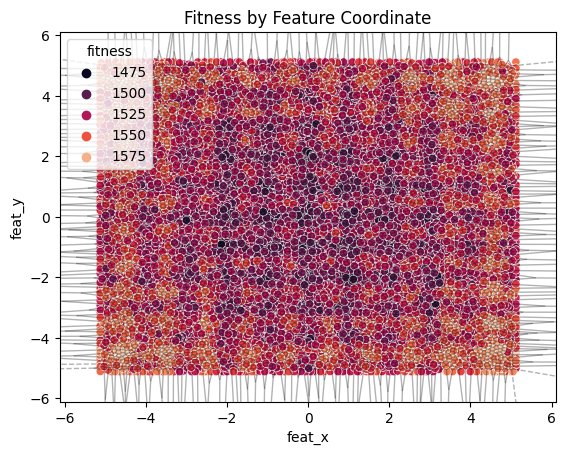

In [14]:
from scipy.spatial import Voronoi, voronoi_plot_2d

fig, ax = plt.subplots()

vor = Voronoi(cell_encoder.centers)
voronoi_plot_2d(vor, ax, line_alpha=0.3, show_points=False, show_vertices=False)

sns.scatterplot(
    data = final_pop_df,
    x="feat_x", y="feat_y",
    hue="fitness", palette="rocket",
    ax=ax
)
plt.title("Fitness by Feature Coordinate")